## Wave Optics: ray tracing

#### Jesse van Rhijn
#### Wilson Tsong

Goals of the assignment:
* In

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from src.ray import Ray
from src.lens import Lens
from src.window import Window
from src.visualizer import Visualizer
%matplotlib inline

In [2]:
matplotlib.rcParams["figure.figsize"] = (20, 10)

In [3]:
def collimated_beam(start, width, nrays, angle=0):
    return [Ray(start, angle, z) for z in np.linspace(-width/2, width/2, nrays)]

In [17]:
diameter_lens = 1e-2
radius_lens = 1.2e-2
refractive_index = 1.5
position_lens = 1e-2

diameter_window = 1e-2
thickness_window = 0.001

beam_width = 0.5e-2

beam = collimated_beam(0, beam_width, 10)

lens = Lens(
    position_lens,
    diameter_lens,
    radius_lens,
    refractive_index
)

position_window = (lens.focal_plane + position_lens)/2

window = Window(
    position_window,
    diameter_window,
    thickness_window,
    refractive_index
)

fp = lens.focal_plane

In [18]:
Lens?
lens.numerical_aperture

0.3944827398232273

In [19]:
lens_rays = lens.interact_with_bundle(beam)
window_rays = window.interact_with_bundle(lens_rays)

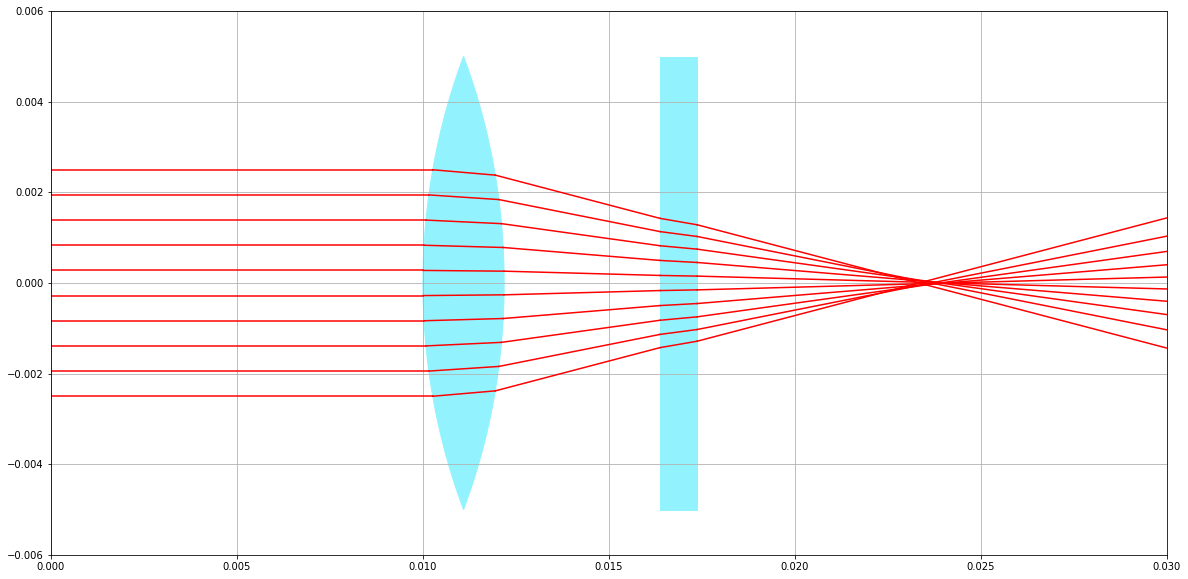

In [24]:
visualizer = Visualizer(beam + list(lens_rays) + list(window_rays), [lens, window], (2e-2, 4e-2))
ax = visualizer.draw_all('r')
_ = ax.set_xlim(0, 0.03)
_ = ax.set_ylim(-0.006, 0.006)
ax.grid(True)
#plt.plot([fp, fp], [-0.5, 0.5], color='black', label="Focal plane")
#_ = plt.legend()

In [25]:
def bundle_width(ray_bundle, xcoords):
    max_dist = np.zeros((len(ray_bundle), len(xcoords)))
    
    for j, ray in enumerate(ray_bundle):
        
        ys = ray.as_coordinate_array(xcoords)
        distances = np.zeros((len(ray_bundle), len(xcoords))) 
        
        for i, other_ray in enumerate(ray_bundle):
            distances[i, :] = np.abs(ys - other_ray.as_coordinate_array(xcoords))
            
        max_distance_to_others = distances.max(axis=0)
        max_dist[j, :] = max_distance_to_others
        
    return max_dist.max(axis=0)

0.02352852852852853 8.526088684886017e-05


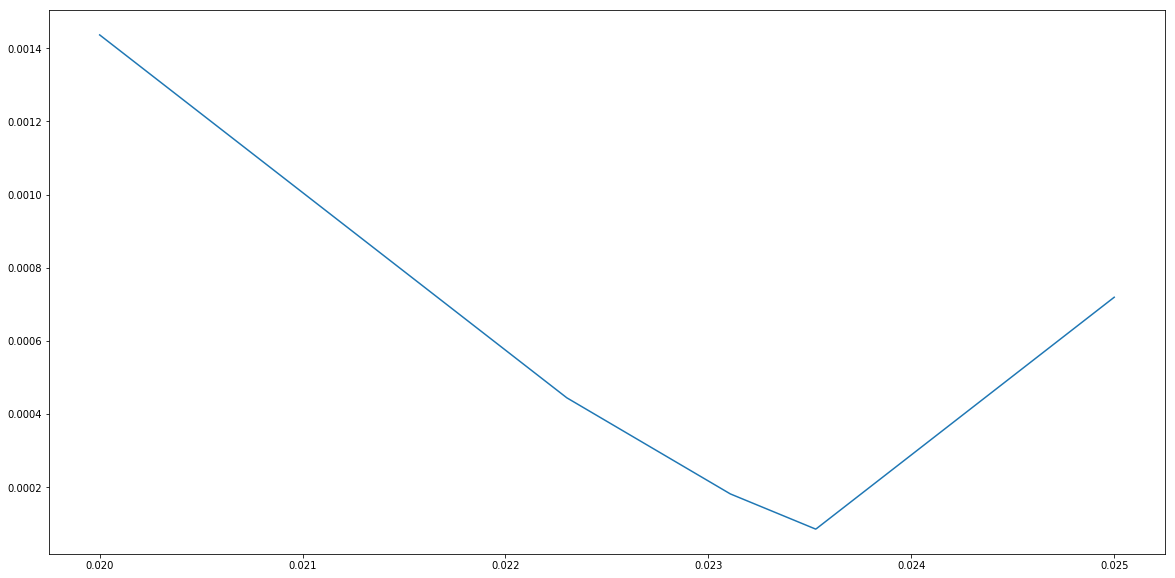

In [26]:
#bundle_width(window_rays, np.linspace(0, 0.2, 100))
xs = np.linspace(0.02, 0.025, 1000)
window_free_rays = window_rays[len(window_rays)//2:]
bw = bundle_width(window_free_rays, xs)
plt.figure()
plt.plot(xs, bw)
print(xs[bw.argmin()], bw.min())